# RL Tutorial | Q-learning, SARSA and on-Policy MC Control

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

In [2]:
env = gym.make("CliffWalking-v0", render_mode="rgb_array")

In [3]:
env.reset(seed=1234)

(36, {'prob': 1})

## Utility Functions

### $\epsilon$-greedy policies

<img src="images/soft_policy.png" width="40%" />

In [4]:
def greedySoftAction(env, q, state, epsilon=0.15):
    """Returns an epsilon greedy action for given state based on Q-values"""
    return (
        env.action_space.sample()
        if np.random.uniform() < epsilon
        else np.argmax(q[state])
    )

# Q-learning

<img src="images/qlearning.png" width="70%" />

In [5]:
def q_learning(env, n_episodes, alpha=0.1, gamma=0.95, epsilon=0.15):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    q = np.zeros((n_states, n_actions))  # Initialize Q-values

    cumulative_reward = np.zeros(n_episodes)
    for i in range(n_episodes):
        state, _ = env.reset()
        while True:
            action = greedySoftAction(env, q, state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)

            # Update values
            q[state][action] = q[state][action] + alpha * (
                reward + gamma * np.max(q[next_state]) - q[state][action]
            )
            state = next_state
            cumulative_reward[i] += reward

            if terminated or truncated:
                break

    return np.argmax(q, axis=1), cumulative_reward

# SARSA

<img src="images/sarsa.png" width="70%" />

In [6]:
def SARSA(env, n_episodes, alpha=0.1, gamma=0.95, epsilon=0.15):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    q = np.zeros((n_states, n_actions))  # Initialize Q-values

    cumulative_reward = np.zeros(n_episodes)
    for i in range(n_episodes):

        state, _ = env.reset()
        while True:
            action = greedySoftAction(env, q, state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)

            # Next action (at next_state)
            next_action = greedySoftAction(env, q, next_state, epsilon)

            # Update values
            q[state][action] = q[state][action] + alpha * (
                reward + gamma * q[next_state][next_action] - q[state][action]
            )
            state = next_state
            action = next_action
            cumulative_reward[i] += reward

            if terminated or truncated:
                break

    return np.argmax(q, axis=1), cumulative_reward

# Monte Carlo Method

<img src="images/MC.png" width="70%" />

In [7]:
def onPolicyMC(env, n_episodes, gamma=0.95, epsilon=0.15):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    q = np.zeros((n_states, n_actions))  # Initialize Q-values

    # Store sum and count of Returns for each (state, action) pair
    returns_sa = np.zeros((n_states, n_actions, 2))
    cumulative_reward = np.zeros(n_episodes)

    for i in range(n_episodes):

        gen_episode = []  # Episode generated [[s0, a0], r1, ... [s_t-1 , a_t-1], r_T]
        state, _ = env.reset()

        while True:
            action = greedySoftAction(env, q, state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)

            # Update values
            gen_episode.append([state, action])
            gen_episode.append(reward)
            cumulative_reward[i] += reward

            state = next_state

            if terminated or truncated:
                break

        # Find 1st visit returns
        g = 0  # return
        for _ in range(len(gen_episode) // 2):
            reward = gen_episode.pop(-1)
            [s, a] = gen_episode.pop(-1)

            g = gamma * g + reward

            if [s, a] not in gen_episode:
                returns_sa[s][a][0] += g
                returns_sa[s][a][1] += 1
                q[s][a] = returns_sa[s][a][0] / returns_sa[s][a][1]

    return np.argmax(q, axis=1), cumulative_reward

## Rewards over episodes (averaged over 10 runs)

In [8]:
def avg_rewards(agent, n_episodes, N=10):
    avg_cum_rewards = []
    for _ in range(10):
        _, cum_rewards = agent(env, n_episodes)
        avg_cum_rewards.append(cum_rewards)

    avg_cum_rewards = np.array(avg_cum_rewards)
    return avg_cum_rewards.mean(axis=0), avg_cum_rewards.std(axis=0)

In [9]:
n_episodes = 250

In [10]:
ql_mean, ql_std = avg_rewards(q_learning, n_episodes)

In [11]:
sarsa_mean, sarsa_std = avg_rewards(SARSA, n_episodes)

In [12]:
mc_mean, mc_std = avg_rewards(onPolicyMC, n_episodes)

In [13]:
def plot_runs(ax, mean, std, label):
    x = np.arange(1, n_episodes + 1)
    ax.plot(x, mean, label=label)
    ax.fill_between(x, mean - 1.96 * std, mean + 1.96 * std, alpha=0.15)

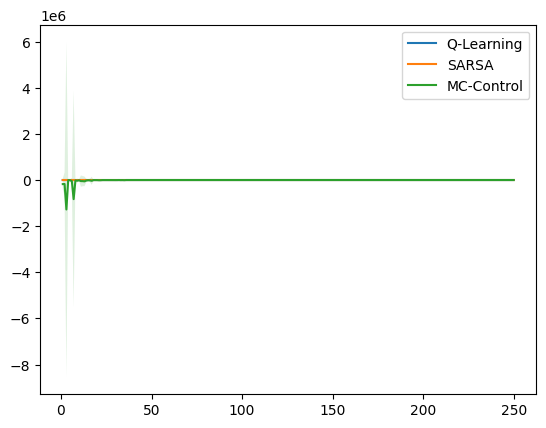

In [14]:
ax = plt.subplot(111)
plot_runs(ax, ql_mean, ql_std, "Q-Learning")
plot_runs(ax, sarsa_mean, sarsa_std, "SARSA")
plot_runs(ax, mc_mean, mc_std, "MC-Control")
plt.legend()